<a href="https://colab.research.google.com/github/vithika-mulye/Bitcoin-Predict/blob/master/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

In [0]:
df = pd.read_csv('coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv')
df.head()
df.index = pd.to_datetime(df['Timestamp'], unit='s')
#df.set_index(['Timestamp'])
#df.head()
df = df.resample('D').mean()
df_month = df.resample('M').mean()
df_year = df.resample('A-DEC').mean()
df_Q = df.resample('Q-DEC').mean()

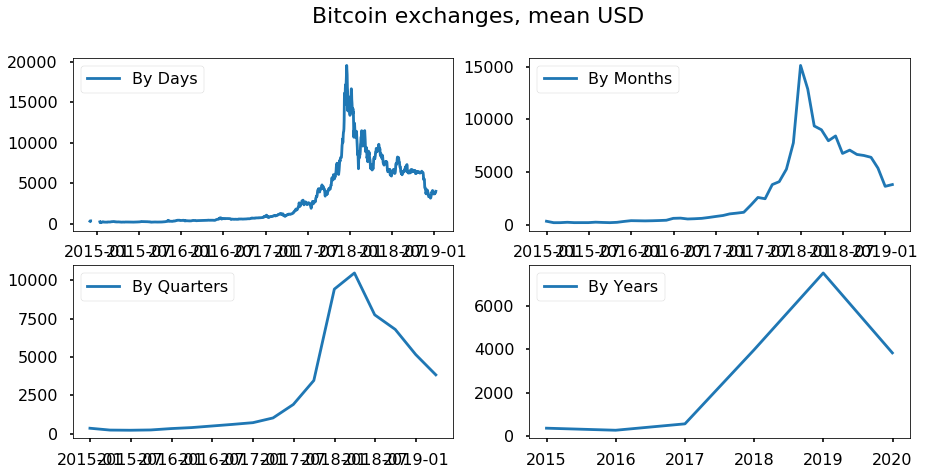

In [121]:
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)
plt.subplot(221)
plt.plot(df.Weighted_Price, '-', label='By Days')
plt.legend()
plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label='By Months')
plt.legend()
plt.subplot(223)
plt.plot(df_Q.Weighted_Price, '-', label='By Quarters')
plt.legend()
plt.subplot(224)
plt.plot(df_year.Weighted_Price, '-', label='By Years')
plt.legend()

Dickey-Fuller test : p = 0.592162


<Figure size 1080x504 with 0 Axes>

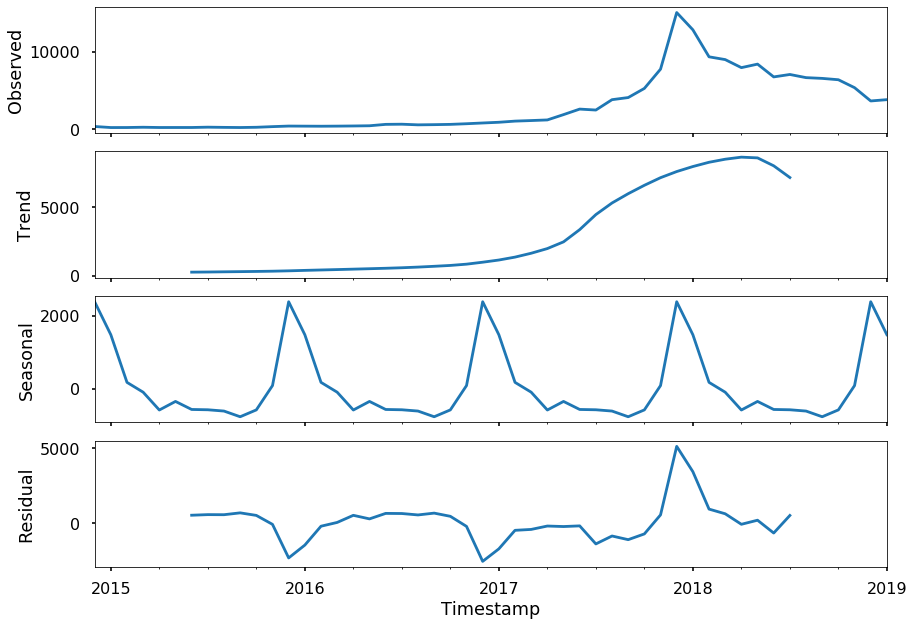

In [122]:
plt.figure(figsize= [15, 7])
sm.tsa.seasonal_decompose(df_month.Weighted_Price).plot()
print("Dickey-Fuller test : p = %f" %sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])
plt.show()

In [123]:
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.Weighted_Price)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])

Dickey–Fuller test: p=0.592162


In [124]:
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.629739


In [135]:
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D = 1
d = 1
parameters = product(Qs, qs, Ps, ps)
param_list = list(parameters)
len(param_list)

54

In [136]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in param_list:
  try:
    model = sm.tsa.statespace.SARIMAX(df_month.Weighted_Price_box, order = (param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 10)).fit(disp = -1)
  except ValueError:
    print('wrong parameters: ', param)
    continue
  aic = model.aic
  if aic < best_aic:
    best_model = model
    best_aic = aic
    best_param = param
  results.append([param, model.aic])

wrong parameters:  (0, 0, 0, 2)
wrong parameters:  (0, 0, 1, 2)
wrong parameters:  (0, 0, 2, 2)
wrong parameters:  (0, 1, 0, 2)
wrong parameters:  (0, 1, 1, 2)
wrong parameters:  (0, 1, 2, 2)
wrong parameters:  (0, 2, 0, 2)
wrong parameters:  (0, 2, 1, 2)
wrong parameters:  (0, 2, 2, 2)
wrong parameters:  (1, 0, 0, 2)
wrong parameters:  (1, 0, 1, 2)
wrong parameters:  (1, 0, 2, 2)
wrong parameters:  (1, 1, 0, 2)
wrong parameters:  (1, 1, 1, 2)
wrong parameters:  (1, 1, 2, 2)
wrong parameters:  (1, 2, 0, 2)
wrong parameters:  (1, 2, 1, 2)
wrong parameters:  (1, 2, 2, 2)


In [137]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending = True).head())
print(best_model.summary())

      parameters        aic
7   (0, 1, 0, 1) -80.703197
19  (1, 0, 0, 1) -80.387719
1   (0, 0, 0, 1) -79.306962
9   (0, 1, 1, 1) -79.222464
25  (1, 1, 0, 1) -79.000533
                                 Statespace Model Results                                 
Dep. Variable:                 Weighted_Price_box   No. Observations:                   50
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 10)   Log Likelihood                  43.352
Date:                            Mon, 02 Mar 2020   AIC                            -80.703
Time:                                    16:38:34   BIC                            -75.713
Sample:                                12-31-2014   HQIC                           -78.913
                                     - 01-31-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

Dickery-Fuller test :: p = 0.000000


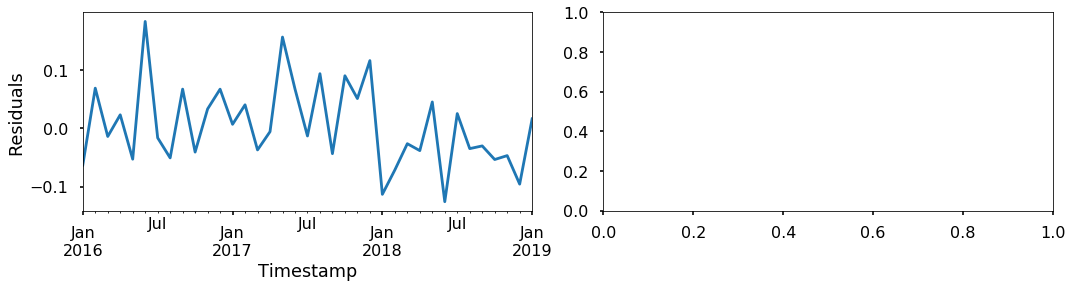

In [138]:
plt.figure(figsize = (15,7))
plt.subplot(221)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(222)
print('Dickery-Fuller test :: p = %f' % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])
plt.tight_layout()
plt.show()

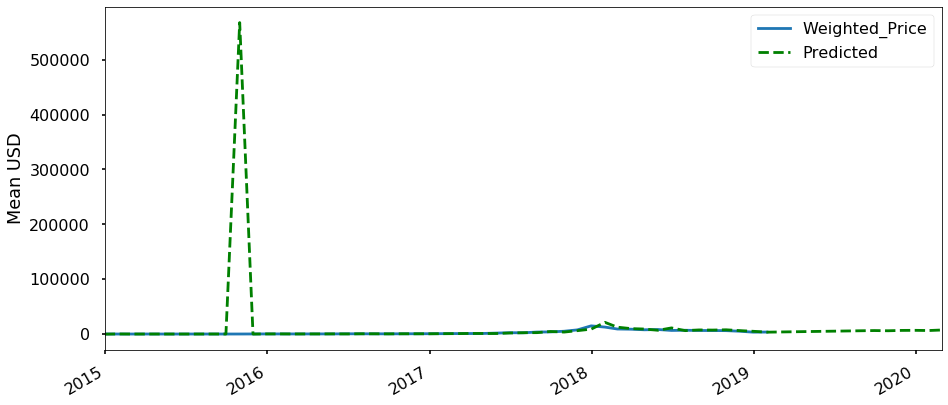

In [139]:
def invboxcox(y, lmbda):
  if lmbda == 0:
    return(np.exp(y))
  else:
    return(np.exp(np.log(lmbda*y+1)/lmbda))
  
df_m2 = df_month[['Weighted_Price']]
date_list = [datetime(2019, 9, 30), datetime(2019, 10, 31), datetime(2019, 11, 30), datetime(2019, 12, 31), datetime(2020, 1, 31), datetime(2020, 2, 29)]
future = pd.DataFrame(index= date_list, columns= df_month.columns)
df_m2 = pd.concat([df_m2, future])
df_m2['forecast'] = invboxcox(best_model.predict(start = 0, end = 100), lmbda)
plt.figure(figsize = (15, 7))
df_m2.Weighted_Price.plot()
df_m2.forecast.plot(color = 'g', ls = '--', label = 'Predicted')
plt.legend()
plt.ylabel('Mean USD')
plt.show()